In [1]:
%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
import platform
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
from scipy.io import netcdf
import ipywidgets as widgets
import pyhazel
import keras
print("Keras version: {0}".format(keras.__version__))

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.
Keras version: 1.0.8


In [2]:
root = '/scratch/Dropbox/GIT/DeepLearning/DNHazel/training/cnns_mu/IQUV-tau_vth_v_a_B_thB_phiB'
f = open('{0}_model.json'.format(root), 'r')
json_string = f.read()
f.close()

model = model_from_json(json_string)
model.load_weights("{0}_weights.hdf5".format(root))

In [3]:
def i0Allen(wavelength, muAngle):
    """
    Return the solar intensity at a specific wavelength and heliocentric angle
    wavelength: wavelength in angstrom
    muAngle: cosine of the heliocentric angle
    """
    C = 2.99792458e10
    H = 6.62606876e-27

    lambdaIC = 1e4 * np.asarray([0.20,0.22,0.245,0.265,0.28,0.30,0.32,0.35,0.37,0.38,0.40,0.45,0.50,0.55,0.60,0.80,1.0,1.5,2.0,3.0,5.0,10.0])
    uData = np.asarray([0.12,-1.3,-0.1,-0.1,0.38,0.74,0.88,0.98,1.03,0.92,0.91,0.99,0.97,0.93,0.88,0.73,0.64,0.57,0.48,0.35,0.22,0.15])
    vData = np.asarray([0.33,1.6,0.85,0.90,0.57, 0.20, 0.03,-0.1,-0.16,-0.05,-0.05,-0.17,-0.22,-0.23,-0.23,-0.22,-0.20,-0.21,-0.18,-0.12,-0.07,-0.07])

    lambdaI0 = 1e4 * np.asarray([0.20,0.22,0.24,0.26,0.28,0.30,0.32,0.34,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.48,0.50,0.55,0.60,0.65,0.70,0.75,\
        0.80,0.90,1.00,1.10,1.20,1.40,1.60,1.80,2.00,2.50,3.00,4.00,5.00,6.00,8.00,10.0,12.0])
    I0 = np.asarray([0.06,0.21,0.29,0.60,1.30,2.45,3.25,3.77,4.13,4.23,4.63,4.95,5.15,5.26,5.28,5.24,5.19,5.10,5.00,4.79,4.55,4.02,3.52,3.06,2.69,2.28,2.03,\
        1.57,1.26,1.01,0.81,0.53,0.36,0.238,0.160,0.078,0.041,0.0142,0.0062,0.0032,0.00095,0.00035,0.00018])
    I0 *= 1e14 * (lambdaI0 * 1e-8)**2 / C

    u = np.interp(wavelength, lambdaIC, uData)
    v = np.interp(wavelength, lambdaIC, vData)
    i0 = np.interp(wavelength, lambdaI0, I0)
    
    return (1.0 - u - v + u * muAngle + v * muAngle**2)* i0

In [4]:
lower = np.asarray([0.05, -5.0, 5.0, 0.0, 0.0, 0.0, -180.0, 0.0])
upper = np.asarray([3.0, 5.0, 18.0, 0.5, 1000.0, 180.0, 180.0, 1.0])
xvalues = []
for i in range(7):
    x = np.linspace(lower[i], upper[i], 30)
    xvalues.append(x)

tauSlider = widgets.FloatSlider(
    value=1.0,
    min=lower[0],
    max=upper[0],
    step=0.1,
    description='tau:',
    continuous_update=False,
)
vSlider = widgets.FloatSlider(
    value=0.0,
    min=lower[1],
    max=upper[1],
    step=0.1,
    description='v:',
    continuous_update=False,
)
vthSlider = widgets.FloatSlider(
    value=8.0,
    min=lower[2],
    max=upper[2],
    step=0.1,
    description='vth:',
    continuous_update=False,
)
aSlider = widgets.FloatSlider(
    value=0.1,
    min=lower[3],
    max=upper[3],
    step=0.01,
    description='a:',
    continuous_update=False,
)
BSlider = widgets.FloatSlider(
    value=100.0,
    min=lower[4],
    max=upper[4],
    step=1,
    description='B:',
    continuous_update=False,
)
thetaSlider = widgets.FloatSlider(
    value=20.0,
    min=lower[5],
    max=upper[5],
    step=1,
    description='theta:',
    continuous_update=False,
)
phiSlider = widgets.FloatSlider(
    value=0.0,
    min=lower[6],
    max=upper[6],
    step=1,
    description='phi:',
    continuous_update=False,
)
muSlider = widgets.FloatSlider(
    value=0.9,
    min=lower[7],
    max=upper[7],
    step=0.05,
    description='mu:',
    continuous_update=False,
)

In [5]:
nLambdaInput = 128
GRIS_dispersion = 0.0362  # A/pix
lowerLambda = 10828
upperLambda = lowerLambda + GRIS_dispersion * nLambdaInput
pyhazel.init()

In [6]:
def compute():
    tau, v, vth, a, B, theta, phi, mu = tauSlider.value, vSlider.value, vthSlider.value, aSlider.value, BSlider.value, thetaSlider.value, phiSlider.value, muSlider.value

    synModeInput = 5
    nSlabsInput = 1

    B1Input = np.asarray([B, theta, phi])    
    B2Input = np.asarray([0.0,0.0,0.0])

    hInput = 3.e0

    tau1Input = tau
    tau2Input = 0.e0

    I0 = i0Allen(10830.0, mu)

    boundaryInput  = np.asarray([I0,0.0,0.0,0.0])

    transInput = 1
    atomicPolInput = 1

    anglesInput = np.asarray([np.arccos(mu)*180/np.pi,0.0,0.0])

    lambdaAxisInput = np.linspace(lowerLambda-10829.0911, upperLambda-10829.0911, nLambdaInput)        

    dopplerWidthInput = vth
    dopplerWidth2Input = 0.e0

    dampingInput = a

    dopplerVelocityInput = v
    dopplerVelocity2Input = 0.e0

    ffInput = 0.e0
    betaInput = 1.0
    beta2Input = 1.0
    nbarInput = np.asarray([0.0,0.0,0.0,0.0])
    omegaInput = np.asarray([0.0,0.0,0.0,0.0])

    nbarInput = np.asarray([1.0,1.0,1.0,1.0])
    omegaInput = np.asarray([1.0,1.0,1.0,1.0])
    normalization = 0

    # Compute the Stokes parameters using many default parameters, using Allen's data
    [l, stokes, etaOutput, epsOutput] = pyhazel.synth(synModeInput, nSlabsInput, B1Input, B2Input, hInput, 
                            tau1Input, tau2Input, boundaryInput, transInput, atomicPolInput, anglesInput, 
                            nLambdaInput, lambdaAxisInput, dopplerWidthInput, dopplerWidth2Input, dampingInput, 
                            dopplerVelocityInput, dopplerVelocity2Input, ffInput, betaInput, beta2Input, nbarInput, omegaInput, normalization)

    return l, stokes

<IPython.core.display.Javascript object>


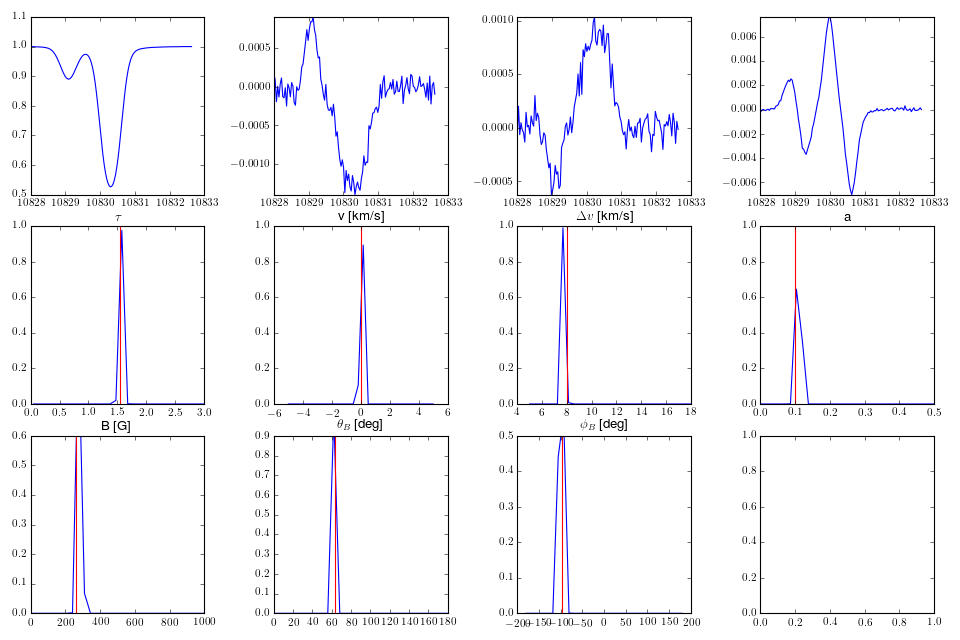

In [11]:
plotpar = {'axes.labelsize': 10,
           'font.size': 10,
           'legend.fontsize': 10,
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'text.usetex': True}
pl.rcParams.update(plotpar)

f, ax = pl.subplots(nrows=3, ncols=4, figsize=(12,8))

synthValue = [tauSlider.value, vSlider.value, vthSlider.value, aSlider.value, BSlider.value, thetaSlider.value, phiSlider.value, muSlider.value]
l, stokes = compute()
stI, = ax[0,0].plot(l,stokes[0,:])
stQ, = ax[0,1].plot(l,stokes[1,:])
stU, = ax[0,2].plot(l,stokes[2,:])
stV, = ax[0,3].plot(l,stokes[3,:])
pl.tight_layout()

inTrain = []
for i in range(4):
    st = np.atleast_3d(stokes[i,:]).reshape((1, 128, 1))
    st += 1e-4 * np.random.randn(1, 128, 1)
    inTrain.append(st.astype('float32'))

inTrain.append(np.atleast_2d(muSlider.value).reshape((1, 1)).astype('float32'))
out = np.asarray(model.predict(inTrain))

label = [r'$\tau$', 'v [km/s]', r'$\Delta v$ [km/s]', 'a', 'B [G]', r'$\theta_B$ [deg]', r'$\phi_B$ [deg]']
lines = [None] * 7
correct = [None] * 7
loop = 0
for j in range(1,3):
    for i in range(4):
        if (loop <= 6):
            lines[loop], = ax[j,i].plot(xvalues[loop], out[loop,0,:])
            correct[loop] = ax[j,i].axvline(synthValue[loop], color='red')
            ax[j,i].set_title(label[loop])
        loop += 1

def update(change):
    l, stokes = compute()
    synthValue = [tauSlider.value, vSlider.value, vthSlider.value, aSlider.value, BSlider.value, thetaSlider.value, phiSlider.value, muSlider.value]
    inTrain = []
    for i in range(4):
        st = np.atleast_3d(stokes[i,:]).reshape((1, 128, 1))
        st += 1e-4 * np.random.randn(1, 128, 1)
        inTrain.append(st.astype('float32'))
    inTrain.append(np.atleast_2d(muSlider.value).reshape((1, 1)).astype('float32'))
    out = np.asarray(model.predict(inTrain))
    
    stI.set_ydata(inTrain[0])
    stQ.set_ydata(inTrain[1])
    ax[0,1].set_ylim([np.min(stokes[1,:]), np.max(stokes[1,:])])
    stU.set_ydata(inTrain[2])
    ax[0,2].set_ylim([np.min(stokes[2,:]), np.max(stokes[2,:])])
    stV.set_ydata(inTrain[3])
    ax[0,3].set_ylim([np.min(stokes[3,:]), np.max(stokes[3,:])])
    
    for i in range(7):
        lines[i].set_ydata(out[i,0,:])
        correct[i].set_xdata(synthValue[i])
        
    f.canvas.draw()

tauSlider.observe(update, names='value')
vSlider.observe(update, names='value')
vthSlider.observe(update, names='value')
aSlider.observe(update, names='value')
BSlider.observe(update, names='value')
thetaSlider.observe(update, names='value')
phiSlider.observe(update, names='value')
muSlider.observe(update, names='value')

HBox1 = widgets.HBox([tauSlider,vSlider,vthSlider])
HBox2 = widgets.HBox([aSlider,muSlider])
HBox3 = widgets.HBox([BSlider,thetaSlider,phiSlider])
widgets.VBox([HBox1,HBox2,HBox3])